In [48]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils
# tells matplotlib to embed plots within the notebook
%matplotlib inline
# define the submission/grader object for this exercise
grader = utils.Grader()

In [66]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    Plots the learned polynomial fit with power p and feature normalization (mu, sigma).

    Parameters
    ----------
    polyFeatures : func
        A function which generators polynomial features from a single feature.

    min_x : float
        The minimum value for the feature.

    max_x : float
        The maximum value for the feature.

    mu : float
        The mean feature value over the training dataset.

    sigma : float
        The feature standard deviation of the training dataset.

    theta : array_like
        The parameters for the trained polynomial linear regression.

    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)

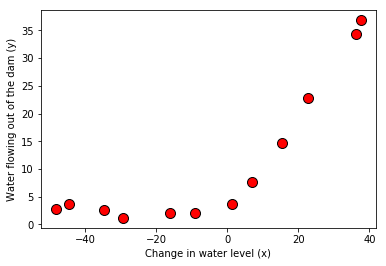

In [49]:
# Load from ex5data1.mat, where all variables will be store in a dictionary
data = loadmat('ex5data1.mat')

# Extract train, test, validation data from dictionary
# and also convert y's form 2-D matrix (MATLAB format) to a numpy vector
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Number of examples
m = y.size

# Plot training data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)');

In [50]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    """
    Compute cost and gradient for regularized linear regression 
    with multiple variables. Computes the cost of using theta as
    the parameter for linear regression to fit the data points in X and y. 
    
    Parameters
    ----------
    X : array_like
        The dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each datapoint. A vector of
        shape (m, ).
    
    theta : array_like
        The parameters for linear regression. A vector of shape (n+1,).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed cost function. 
    
    grad : array_like
        The value of the cost function gradient w.r.t theta. 
        A vector of shape (n+1, ).
    
    Instructions
    ------------
    Compute the cost and gradient of regularized linear regression for
    a particular choice of theta.
    You should set J to the cost and grad to the gradient.
    """
    # Initialize some useful values
    m = y.size # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    J += np.matmul((np.matmul(X,theta)-y),(np.matmul(X,theta)-y))
    J += (lambda_)*np.matmul(theta,theta)
    J -= (lambda_)*(theta[0]*theta[0])
    J /= (2*m)
    grad = np.matmul((np.matmul(X,theta)-y),X)+(lambda_)*(theta)
    grad[0] -= (lambda_)*(theta[0])
    grad /= m
    # ============================================================
    return J, grad

In [51]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192)\n' % J)

Cost at theta = [1, 1]:	   303.993192 
This value should be about 303.993192)



In [52]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Gradient at theta = [1, 1]:  [-15.303016, 598.250744] 
 (this value should be about [-15.303016, 598.250744])



In [53]:
def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.
    Parameters
    ----------
    X : array_like
        The dataset with shape (m x n+1). The bias term is assumed to be concatenated.
    y : array_like
        Function values at each datapoint. A vector of shape (m,).
    lambda_ : float, optional
        The regularization parameter.
    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.
    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

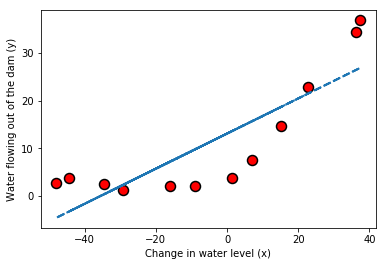

In [54]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Plot fit over the data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);

In [71]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    """
    Generates the train and cross validation set errors needed to plot a learning curve
    returns the train and cross validation set errors for a learning curve. 
    
    In this function, you will compute the train and test errors for
    dataset sizes from 1 up to m. In practice, when working with larger
    datasets, you might want to do this in larger intervals.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    error_train : array_like
        A vector of shape m. error_train[i] contains the training error for
        i examples.
    error_val : array_like
        A vecotr of shape m. error_val[i] contains the validation error for
        i training examples.
    
    Instructions
    ------------
    Fill in this function to return training errors in error_train and the
    cross validation errors in error_val. i.e., error_train[i] and 
    error_val[i] should give you the errors obtained after training on i examples.
    
    Notes
    -----
    - You should evaluate the training error on the first i training
      examples (i.e., X[:i, :] and y[:i]).
    
      For the cross-validation error, you should instead evaluate on
      the _entire_ cross validation set (Xval and yval).
    
    - If you are using your cost function (linearRegCostFunction) to compute
      the training and cross validation error, you should call the function with
      the lambda argument set to 0. Do note that you will still need to use
      lambda when running the training to obtain the theta parameters.
    
    Hint
    ----
    You can loop over the examples with the following:
     
           for i in range(1, m+1):
               # Compute train/cross validation errors using training examples 
               # X[:i, :] and y[:i], storing the result in 
               # error_train[i-1] and error_val[i-1]
               ....  
    """
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    for i in range(1,m+1):
        theta = trainLinearReg(linearRegCostFunction, X[:i,:], y[:i], lambda_ = lambda_)
        error_train[i-1],_ = linearRegCostFunction(X[:i,:] ,y[:i], theta, lambda_=0.0)
        error_val[i-1],_ = linearRegCostFunction(Xval ,yval, theta, lambda_=0.0)
    # =============================================================
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368910
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


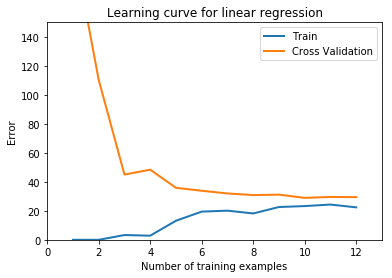

In [72]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

In [73]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================
    for i in range(X.shape[0]):
        for j in range(p): 
            X_poly[i,j]=X[i]**(j+1)
    # ============================================================
    return X_poly

In [74]:
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the mean value of each
    feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when
    working with learning algorithms.

    Parameters
    ----------
    X : array_like
        An dataset which is a (m x n) matrix, where m is the number of examples,
        and n is the number of dimensions for each example.

    Returns
    -------
    X_norm : array_like
        The normalized input dataset.

    mu : array_like
        A vector of size n corresponding to the mean for each dimension across all examples.

    sigma : array_like
        A vector of size n corresponding to the standard deviations for each dimension across
        all examples.
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma


In [75]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

Polynomial Regression (lambda = 100.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	138.846777
  	2		0.114107	144.125230
  	3		106.956580	70.863286
  	4		121.740879	78.372963
  	5		102.949459	63.845046
  	6		97.169857	59.532632
  	7		83.326539	59.585493
  	8		76.491825	58.699842
  	9		71.297176	59.564455
  	10		64.350636	59.731344
  	11		58.997943	60.409869
  	12		57.977080	57.842195


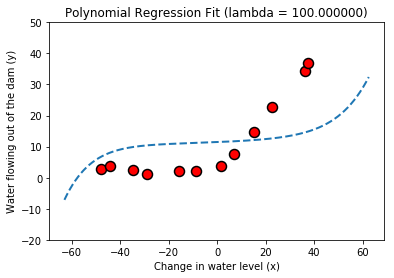

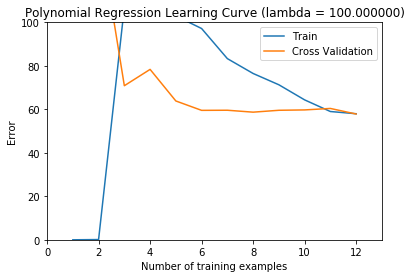

In [76]:
lambda_ = 100
theta = trainLinearReg(linearRegCostFunction, X_poly, y,lambda_=lambda_, maxiter=55)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

In [79]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    
    Instructions
    ------------
    Fill in this function to return training errors in `error_train` and
    the validation errors in `error_val`. The vector `lambda_vec` contains
    the different lambda parameters to use for each calculation of the
    errors, i.e, `error_train[i]`, and `error_val[i]` should give you the
    errors obtained after training with `lambda_ = lambda_vec[i]`.

    Note
    ----
    You can loop over lambda_vec with the following:
    
          for i in range(len(lambda_vec))
              lambda = lambda_vec[i]
              # Compute train / val errors when training linear 
              # regression with regularization parameter lambda_
              # You should store the result in error_train[i]
              # and error_val[i]
              ....
    """
    # Selected values of lambda (you should not change this)
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    # ====================== YOUR CODE HERE ======================
    for i in range(len(lambda_vec)):
        lambda_ = lambda_vec[i]
        theta = trainLinearReg(linearRegCostFunction, X, y, lambda_)
        error_train[i],_=linearRegCostFunction(X, y, theta, lambda_=0.0)
        error_val[i],_=linearRegCostFunction(Xval, yval, theta, lambda_=0.0)
    # ============================================================
    return lambda_vec, error_train, error_val

lambda		Train Error	Validation Error
 0.000000	0.031517	39.224451
 0.001000	0.112899	9.865825
 0.003000	0.170968	16.305941
 0.010000	0.221484	16.950261
 0.030000	0.281818	12.830211
 0.100000	0.459318	7.587007
 0.300000	0.921759	4.636832
 1.000000	2.076201	4.260600
 3.000000	4.901379	3.822906
 10.000000	16.092273	9.945554


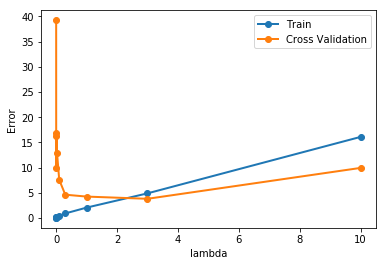

In [80]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))